# Synthetic batch dictionary

In [8]:
import torch

B = 5

def get_batch(
    batch_size=5,
    N_max=200,
    protein_max=15,
    protein_min=5,
    dna_max=10,
    dna_min=6,
    rna_max=10,
    rna_min=5,
    ligand_max=60,
    ligand_min=20,
    seed=0
):
    
    torch.manual_seed(0)
    #----------------------------------------
    # Token 
    #----------------------------------------

    B = batch_size
    T_protein = torch.randint(protein_min, protein_max, (B,)) # [B]
    T_dna = torch.randint(dna_min, dna_max, (B,)) # [B]
    T_rna = torch.randint(rna_min, rna_max, (B,)) # [B]
    T_ligand = torch.randint(ligand_min, ligand_max, (B,)) # [B]

    T = T_protein + T_dna + T_rna + T_ligand

    #----------------------------------------
    # Atom sizes
    #----------------------------------------

    protein_sizes = [torch.randint(3,14, (T_protein[i],)) for i in range(B)]
    N_protein = torch.tensor([x.sum(-1) for x in protein_sizes]) # [B]
    dna_sizes = [torch.randint(5,10, (T_dna[i],)) for i in range(B)]
    N_dna = torch.tensor([x.sum(-1) for x in dna_sizes]) # [B]
    rna_sizes = [torch.randint(5,10, (T_rna[i],)) for i in range(B)]
    N_rna = torch.tensor([x.sum(-1) for x in rna_sizes]) # [B]
    N_ligand = T_ligand # [B]

    # concatenate sizes
    sizes = [torch.cat([protein_sizes[i], dna_sizes[i], rna_sizes[i], torch.ones(N_ligand[i])]) for i in range(B)]
    sizes = [x.to(torch.int64) for x in sizes]

    N = N_protein + N_dna + N_rna + N_ligand

    if N.max() > N_max:
        N_max = N.max().item()

    #----------------------------------------
    # atom mask (padding)
    #----------------------------------------

    atom_mask = torch.zeros(B, N_max)
    for i in range(B):
        atom_mask[i, :N[i]] = 1

    #----------------------------------------
    # token_mask (padding)
    #----------------------------------------

    T_max = T.max()
    token_mask = torch.zeros(B, T_max)
    for i in range(B):
        token_mask[i, :T[i]] = 1

        
    #----------------------------------------
    # 'is' feature
    #----------------------------------------

    is_protein = torch.zeros(B, T_max) # [B, T_max]
    for i in range(B):
        a = T_protein[i].item()
        is_protein[i, :a] = 1

    is_dna = torch.zeros(B, T_max) # [B, T_max]
    for i in range(B):
        a = T_protein[i].item()
        b = a + T_dna[i].item()
        is_dna[i, a:b] = 1

    is_rna = torch.zeros(B, T_max) # [B, T_max]
    for i in range(B):
        a = T_protein[i].item() + T_dna[i].item()
        b = a + T_rna[i].item()
        is_rna[i, a:b] = 1

    is_ligand = torch.zeros(B, T_max) # [B, T_max]
    for i in range(B):
        a = T_protein[i].item() + T_dna[i].item() + T_rna[i].item()
        b = a + T_ligand[i].item()
        is_ligand[i, a:b] = 1

    #----------------------------------------
    # Valid frame
    #----------------------------------------

    valid_frame = token_mask.clone()
    valid_frames = [torch.bernoulli(0.95 * torch.ones(N_ligand[i])) for i in range(B)]
    for i in range(B):
        T_shift = T_protein[i] + T_dna[i] + T_rna[i]
        valid_frame[i, T_shift:T_shift+N_ligand[i]] = valid_frames[i]

    #----------------------------------------
    # atom mask ground truth
    #----------------------------------------

    atom_resolved = torch.bernoulli(0.95 * torch.ones(B, N_max))
    atom_mask_gt = atom_mask * atom_resolved

    #----------------------------------------
    # frame index
    #----------------------------------------

    # for each token get indices of three atoms associated with that toekn
    frame_index = torch.zeros(B, T_max, 3)  
    for i in range(B):
        t_running = 0
        for t in range(T[i]):
            if is_ligand[i, t] == 0:
                # sample 3 atoms from t_running to t_running+sizes[i][t]
                atoms = torch.randperm(sizes[i][t])[:3]
                atoms += t_running
                t_running += sizes[i][t]
            
            else:
                atoms = torch.randperm(N_ligand[i])[:3]
                atoms += t_running
            
            

            frame_index[i, t] = atoms

    batch = {}
    batch['N_max'] = N_max
    batch['T_max'] = T_max
    batch['atom_mask'] = atom_mask
    batch['token_mask'] = token_mask
    batch['is_protein'] = is_protein
    batch['is_dna'] = is_dna
    batch['is_rna'] = is_rna
    batch['is_ligand'] = is_ligand
    batch['valid_frame'] = valid_frame
    batch['atom_mask_gt'] = atom_mask_gt
    batch['frame_index'] = frame_index

    return batch


# 

In [12]:
torch.manual_seed(12345)
B = 5
batch = get_batch(batch_size=B)
N = batch['N_max']

x_gt = torch.zeros(B, N, 3) * batch['atom_mask_gt'].unsqueeze(-1) # [B, N, 3]

# shifts and rotations
shifts = torch.randn(B, 1, 3)
R, _, _ = torch.linalg.svd(torch.randn(B, 1, 3, 3)) # [B, 1, 3, 3]

x = (R @ x_gt[..., None]).squeeze(-1) + shifts
noise = torch.randn_like(x) * 0.5
x += noise

logits = torch.randn(B, N, 50)

## pLDDT

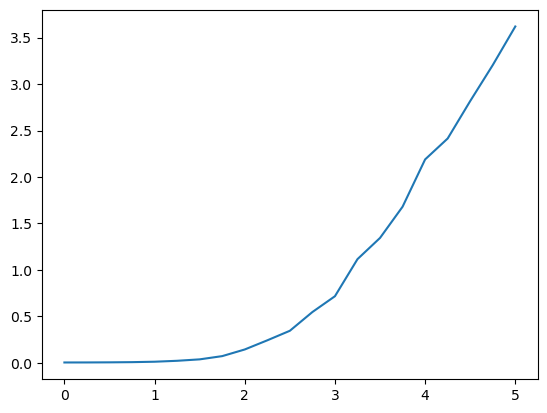

In [83]:
import matplotlib.pyplot as plt
import torch.nn.functional as F
from confidence import pLDDT

atom_mask_gt = batch['atom_mask_gt']
atom_mask = batch['atom_mask']
valid_frame = batch['valid_frame']
frame_idx = batch['frame_index'].to(torch.int64)
is_protein = batch['is_protein'].to(torch.int64)
is_rna = batch['is_rna'].to(torch.int64)
is_dna = batch['is_dna'].to(torch.int64)
eps = 1e-8

#----------------------------------------
# GET "TARGET" LOGITS TO TEST LOSS
#----------------------------------------
dx = torch.cdist(x, x)  # [*, N, N]
dx_gt = torch.cdist(x_gt, x_gt)  # [*, N, N]
delta = torch.abs(dx - dx_gt)  # [*, N, N]

Ca_mask = frame_idx[..., 1] * is_protein  # [*, T]
Ca_mask = F.one_hot(Ca_mask, num_classes=dx.shape[-1]).sum(dim=-2)  # [*, N]

C1_mask = frame_idx[..., 1] * (is_dna + is_rna)  # [*, T]
C1_mask = F.one_hot(C1_mask, num_classes=dx.shape[-1]).sum(dim=-2)  # [*, N]

# Restrict to bespoke inclusion radius
c = ((dx_gt < 30.0) * Ca_mask.unsqueeze(-2) + 
        (dx_gt < 15.0) * C1_mask.unsqueeze(-2))  # [*, N, N]

# atom mask and avoid self term
# TODO check dtypes for masks
mask = 1 - torch.eye(c.shape[-1], device=c.device)  # [N, N]
mask = mask * atom_mask_gt[..., None] * atom_mask_gt[..., None, :]  # [*, N, N]
c = c * mask  # [*, N, N]

thresholds = torch.tensor([0.5, 1.0, 2.0, 4.0]).to(dx.device)
lddt = torch.where(delta[..., None] < thresholds, 1.0, 0.0).sum(-1)  # [*, N, N]
# TODO: shouldn't this be normalized? (normalized here...)
lddt = 0.25 * (lddt * c).sum(dim=-1) / (c.sum(dim=-1) + eps)  # [*, N]

boundaries = torch.linspace(
        0.0, 1.0, 50 + 1, device=lddt.device
        )  # [n_bins + 1]
bins = torch.bucketize(lddt, boundaries[1:-1])  # [*, N]

# set bin to ignore value (=-100) of F.cross_entropy for masked atoms
#bins = bins.masked_fill_(~atom_mask_gt.bool(), -100)  # [*, N]

# turn bins into one hot
bins = F.one_hot(bins, num_classes=50)  # [*, N, 50]
bins = bins * atom_mask_gt[..., None]  # [*, N, 50]
bins = torch.where(bins==0, torch.tensor(1e-4).to(bins.device), bins)
logits = torch.log(bins)

noise = torch.linspace(0, 5, 21)
losses = []
for a in noise:
        logits_n = logits + a * torch.randn_like(logits)

        loss = pLDDT(x, x_gt, frame_idx, atom_mask_gt, is_protein, is_dna, is_rna, logits_n)
        losses.append(loss.item())

plt.plot(noise, losses)
plt.show()

# Predicted Distance Error

In [90]:
from confidence import predictedDistanceError

T = batch['T_max']

logits = torch.randn(B, T, T, 64)

pde, PDE = predictedDistanceError(x, x_gt, frame_idx, logits)

print(pde)

print(PDE.shape)

tensor(4.6622)
torch.Size([5, 78, 78])


# Experimentally Resolved Predictions

In [92]:
from confidence import experimentally_resolved_prediction

logits = torch.randn(B, N, 2)
atom_mask_gt = batch['atom_mask_gt']
atom_mask = batch['atom_mask']

loss = experimentally_resolved_prediction(atom_mask_gt, atom_mask, logits)
loss

tensor(0.9144)